In [34]:
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import pprint

pp = pprint.PrettyPrinter(indent=5)

In [35]:
print("reading data set....")
training_data_set = pd.read_csv("/Users/prajwalkrishn/Desktop/My_Computer/project - Dsci 601/Offensive_Tweet_Detection/Dataset/MOLID.csv")
print("Done reading....")


reading data set....
Done reading....


In [36]:
training_data_set.head(5)

,tweet,subtask_a,subtask_b,subtask_c
0,This is Dubai's like Michael 's phone went pud...,Offensive,UNT,NaN
1,"In fact, never was perceived to be thrown. Eve...",Offensive,TIN,IND
2,Bhosadi I am your mother's husband. Look at yo...,Offensive,TIN,IND
3,If you ask a dog? And the smoke is drawn throu...,Offensive,TIN,IND
4,Where's Ram Kadam went to talk to the BJP and ...,Offensive,TIN,GRP


In [37]:
tweets = training_data_set[["tweet"]]
level_A_labels = training_data_set[["subtask_a"]]
level_B_labels = training_data_set.query("subtask_a == 'Offensive'")[["subtask_b"]]
level_C_labels = training_data_set.query("subtask_b == 'TIN'")[["subtask_c"]]

All_Cleaned_tweets = copy.deepcopy(tweets)

In [38]:
##Data Cleaning and Pre-Processing

In [39]:
tweets.head(5)

,tweet
0,This is Dubai's like Michael 's phone went pud...
1,"In fact, never was perceived to be thrown. Eve..."
2,Bhosadi I am your mother's husband. Look at yo...
3,If you ask a dog? And the smoke is drawn throu...
4,Where's Ram Kadam went to talk to the BJP and ...


In [40]:
level_A_labels.head(5)

,subtask_a
0,Offensive
1,Offensive
2,Offensive
3,Offensive
4,Offensive


In [41]:
level_B_labels.head(5)

,subtask_b
0,UNT
1,TIN
2,TIN
3,TIN
4,TIN


In [42]:
level_C_labels.head(5)

,subtask_c
1,IND
2,IND
3,IND
4,GRP
5,IND


In [43]:
All_Cleaned_tweets.head(5)

,tweet
0,This is Dubai's like Michael 's phone went pud...
1,"In fact, never was perceived to be thrown. Eve..."
2,Bhosadi I am your mother's husband. Look at yo...
3,If you ask a dog? And the smoke is drawn throu...
4,Where's Ram Kadam went to talk to the BJP and ...


In [44]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer,WordNetLemmatizer
lancaster = LancasterStemmer()
wordNet = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prajwalkrishn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prajwalkrishn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def remove_webTags_UserNames_Noise(tweet):
    things_to_be_removed_from_tweets = ['URL','@USER','\'ve','n\'t','\'s','\'m']
    
    for things in things_to_be_removed_from_tweets:
        tweet = tweet.replace(things,'')
    
    return re.sub(r'[^a-zA-Z]', ' ', tweet)

def stop_words_removal(tokens):
    cleaned_tokens = []
    stop = set(stopwords.words('english'))
    for token in tokens:
        if token not in stop:
            if token.replace(' ','') != '':
                if len(token) > 1:
                    cleaned_tokens.append(token)
    return cleaned_tokens

def tokenize(tweet):
    lower_cased_tweet = tweet.lower()
    return word_tokenize(lower_cased_tweet)

def stemming(tokens):
    cleaned_tokens = []
    for token in tokens:
        token = lancaster.stem(token)
        if len(token) > 1:
            cleaned_tokens.append(token)
    return cleaned_tokens

def lemmatization(tokens):
    cleaned_tokens = []
    for token in tokens:
        token = wordNet.lemmatize(token)
        if len(token) > 1:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [46]:
tqdm.pandas(desc = "clean...")
All_Cleaned_tweets['tweet'] = tweets['tweet'].progress_apply(remove_webTags_UserNames_Noise)

tqdm.pandas(desc="Tokenize..")
All_Cleaned_tweets['tokens'] = All_Cleaned_tweets['tweet'].progress_apply(tokenize)

tqdm.pandas(desc="remove STOPWORDS...")
All_Cleaned_tweets['tokens'] = All_Cleaned_tweets['tokens'].progress_apply(stop_words_removal)

tqdm.pandas(desc="Stemming...")
All_Cleaned_tweets['tokens'] = All_Cleaned_tweets['tokens'].progress_apply(stemming)

tqdm.pandas(desc="Lemmatize...")
All_Cleaned_tweets['tokens'] = All_Cleaned_tweets['tokens'].progress_apply(lemmatization)

text_vector = All_Cleaned_tweets['tokens'].tolist()

Lemmatize...: 100%|██████████| 2499/2499 [00:00<00:00, 42779.46it/s]


In [47]:
All_Cleaned_tweets.head(5)

,tweet,tokens
0,This is Dubai like Michael phone went pudica,"[duba, lik, michael, phon, went, pudic]"
1,In fact never was perceived to be thrown Eve...,"[fact, nev, perceiv, thrown, everyth, mov, tow..."
2,Bhosadi I am your mother husband Look at your...,"[bhosad, moth, husband, look, moth, as, kil, d..."
3,If you ask a dog And the smoke is drawn throu...,"[ask, dog, smok, drawn, rub, goat, alon, kang,..."
4,Where Ram Kadam went to talk to the BJP and no...,"[ram, kadam, went, talk, bjp, behavy, mut, con..."


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfid(text_vector):
    vectorizer = TfidfVectorizer()
    untokenized_data =[' '.join(tweet) for tweet in tqdm(text_vector, "Vectorizing...")]
    vectorizer = vectorizer.fit(untokenized_data)
    vectors = vectorizer.transform(untokenized_data).toarray()
    return vectors
  
def get_vectors(vectors, labels, keyword):
    if len(vectors) != len(labels):
        print("Unmatching sizes!")
        return
    result = list()
    for vector, label in zip(vectors, labels):
        if label == keyword:
            result.append(vector)
    return result

In [49]:
vectors_level_a = tfid(text_vector) # Numerical Vectors A
labels_level_a = level_A_labels['subtask_a'].values.tolist() # Subtask A Labels

vectors_level_b = get_vectors(vectors_level_a, labels_level_a, "Offensive") # Numerical Vectors B
labels_level_b = level_B_labels['subtask_b'].values.tolist() # Subtask B Labels

vectors_level_c = get_vectors(vectors_level_b, labels_level_b, "TIN") # Numerical Vectors C
labels_level_c = level_C_labels['subtask_c'].values.tolist() # Subtask C Labels

Vectorizing...: 100%|██████████| 2499/2499 [00:00<00:00, 1883141.52it/s]


In [50]:
pp.pprint(vectors_level_a)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])


In [51]:
pp.pprint(labels_level_c)

[    'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'GRP',
     'GRP',
     'IND',
     'IND',
     'GRP',
     'GRP',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'GRP',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'GRP',
     'IND',
     'GRP',
     'IND',
     'GRP',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'GRP',
     'IND',
     'IND',
     'IND',
     'IND',
     'IND',
     'GRP',
     'IND',
     'IND',
     'IND',
     'GRP',
    

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_a[:], labels_level_a[:], train_size=0.70)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_b[:], labels_level_b[:], train_size=0.75)

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

print("fit begins...")
warnings.filterwarnings(action='ignore')
classifier = DecisionTreeClassifier(max_depth=800, min_samples_split=5)
params = {'criterion':['gini','entropy']}
classifier = GridSearchCV(classifier, params, cv=3, n_jobs=4)
classifier.fit(train_vectors, train_labels)
classifier = classifier.best_estimator_
print("fit complete....")

print("calculating accuracy....")
accuracy = accuracy_score(train_labels, classifier.predict(train_vectors))
print("Training Accuracy:", accuracy)
test_predictions = classifier.predict(test_vectors)
accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", accuracy)
print("Confusion Matrix:", )
print(confusion_matrix(test_labels, test_predictions))
print(classification_report(test_labels,test_predictions))

fit begins...
fit complete....
calculating accuracy....
Training Accuracy: 0.9590909090909091
Test Accuracy: 0.7142857142857143
Confusion Matrix:
[[ 9 14  4]
 [11 92  3]
 [ 1  9  4]]
              precision    recall  f1-score   support

         GRP       0.43      0.33      0.38        27
         IND       0.80      0.87      0.83       106
         OTH       0.36      0.29      0.32        14

    accuracy                           0.71       147
   macro avg       0.53      0.50      0.51       147
weighted avg       0.69      0.71      0.70       147



SVM model experiment begins ...
fit begins...
dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.6s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   8.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   8.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .................... C=1, gamma=0.0001, kernel=rbf, total=   8.1s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.4min finished


fit complete....
calculating accuracy....
Training Accuracy: 0.985134362492853
Test Accuracy: 0.8653333333333333
Confusion Matrix:
[[186  64]
 [ 37 463]]
               precision    recall  f1-score   support

    Offensive       0.83      0.74      0.79       250
not offensive       0.88      0.93      0.90       500

     accuracy                           0.87       750
    macro avg       0.86      0.83      0.84       750
 weighted avg       0.86      0.87      0.86       750



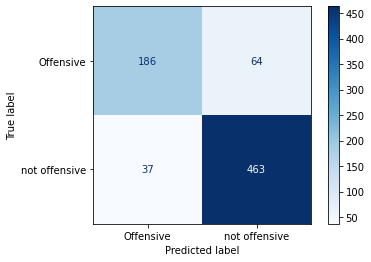

In [58]:
print("SVM model experiment begins ...")
import warnings
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_a[:], labels_level_a[:], train_size=0.70)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_b[:], labels_level_b[:], train_size=0.75)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

classNames = np.unique(test_labels)
print("fit begins...")
warnings.filterwarnings(action='ignore')
classifiersvc = SVC()
print(classifiersvc.get_params().keys())
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
classifierGrid = GridSearchCV(classifiersvc, param_grid, refit = True, verbose=2)
classifierGrid.fit(train_vectors, train_labels)
classifierGrid = classifierGrid.best_estimator_
print("fit complete....")


print("calculating accuracy....")
accuracy = accuracy_score(train_labels, classifierGrid.predict(train_vectors))
print("Training Accuracy:", accuracy)
test_predictions = classifierGrid.predict(test_vectors)
accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", accuracy)
print("Confusion Matrix:", )
matrix = confusion_matrix(test_labels, test_predictions)
print(confusion_matrix(test_labels, test_predictions))
print(classification_report(test_labels,test_predictions))

plottedCM = plot_confusion_matrix(classifierGrid, test_vectors, test_labels,display_labels=classNames, cmap=plt.cm.Blues)
plt.show()

In [ ]:
print("RandomForest model experiment begins ...")
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_a[:], labels_level_a[:], train_size=0.70)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_b[:], labels_level_b[:], train_size=0.75)

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

print("fit begins...")
warnings.filterwarnings(action='ignore')
classifierRFC = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
print(classifierRFC.get_params().keys())
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
classifierGrid = GridSearchCV(classifierRFC, param_grid, refit = True, verbose=2)
classifierGrid.fit(train_vectors, train_labels)
classifierGrid = classifierGrid.best_estimator_
print("fit complete....")


print("calculating accuracy....")
accuracy = accuracy_score(train_labels, classifierGrid.predict(train_vectors))
print("Training Accuracy:", accuracy)
test_predictions = classifierGrid.predict(test_vectors)
accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", accuracy)
print("Confusion Matrix:", )
print(confusion_matrix(test_labels, test_predictions))
print(classification_report(test_labels,test_predictions))

In [ ]:
print("MNB model experiment begins ...")
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_a[:], labels_level_a[:], train_size=0.70)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_b[:], labels_level_b[:], train_size=0.75)

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

print("fit begins...")
warnings.filterwarnings(action='ignore')
classifierMNB = MultinomialNB()
# print(classifierMNB.get_params().keys())
param_grid = { 
    'alpha': [1, 10, 100, 1000],
    'fit_prior': [True, False]
}
classifierGrid = GridSearchCV(classifierMNB, param_grid, refit = True, verbose=2, n_jobs=2)
classifierGrid.fit(train_vectors, train_labels)
classifierGrid = classifierGrid.best_estimator_
print("fit complete....")


print("calculating accuracy....")
accuracy = accuracy_score(train_labels, classifierGrid.predict(train_vectors))
print("Training Accuracy:", accuracy)
test_predictions = classifierGrid.predict(test_vectors)
accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", accuracy)
print("Confusion Matrix:", )
print(confusion_matrix(test_labels, test_predictions))
print(classification_report(test_labels,test_predictions))


In [ ]:
print("KNN model experiment begins ...")
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_a[:], labels_level_a[:], train_size=0.70)

#train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_b[:], labels_level_b[:], train_size=0.75)

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors_level_c[:], labels_level_c[:], train_size=0.75)

print("fit begins...")
warnings.filterwarnings(action='ignore')
classifierKNN = KNeighborsClassifier()
#print(classifierKNN.get_params().keys())
param_grid = { 
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1]
}
classifierGrid = GridSearchCV(classifierKNN, param_grid, refit = True, verbose=2, n_jobs=2)
classifierGrid.fit(train_vectors, train_labels)
classifierGrid = classifierGrid.best_estimator_
print("fit complete....")


print("calculating accuracy....")
accuracy = accuracy_score(train_labels, classifierGrid.predict(train_vectors))
print("Training Accuracy:", accuracy)
test_predictions = classifierGrid.predict(test_vectors)
accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", accuracy)
print("Confusion Matrix:", )
print(confusion_matrix(test_labels, test_predictions))
print(classification_report(test_labels,test_predictions))
